In [11]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MultiLabelBinarizer
# Importing libraries for MLOps simulation, as required by the outline
import json 
from collections import defaultdict 
# import pyjanitor, pandas_profiling, great_expectations, dvc (Simulated)

# Set random seed for reproducibility (crucial for probabilistic cast)
np.random.seed(42)

# --- 1. Load Data ---
file_name = "main DS copy - cast and place matches (1).csv"
df = pd.read_csv(file_name)

print("--- Experiment 2: Advanced Feature Engineering (MLOps Simulation) ---")
print(f"Initial Dataset Size: {len(df)} rows")


# --- SIMULATION: PANDAS PROFILING (Step 1 of Outline) ---
print("\n[Profiling Report Simulation: Initial Data Audit]")
# 1. Detect Missing Values (NaN)
print("\nInitial Missing Value Report (Top Columns with NaNs):")
print(df[['view_count', 'like_count', 'comment_count', 'Released_on', 'publish_date']].isnull().sum())

# 2. Detect Outliers/Data Distribution
print("\nInitial View Count Distribution Summary:")
print(df['view_count'].describe())
print("-" * 50)


# --- 2. DATA CLEANING (Step 2 of Outline) ---

# 2a. Clean Missing Values (Imputation and Dropping)
count_cols = ['view_count', 'like_count', 'comment_count']
df[count_cols] = df[count_cols].fillna(0).astype(int) # Impute count NaNs with 0
df['Released_on'] = pd.to_datetime(df['Released_on'], errors='coerce')
df['publish_date'] = pd.to_datetime(df['publish_date'], errors='coerce')
df = df.dropna(subset=['Released_on', 'publish_date']) # Drop rows where dates could not be parsed

# 2b. Clean Duplicates and Text Columns
df = df.drop(columns=['channel_title'])
df['place_matches_cleaned'] = df['place_matches_cleaned'].fillna('UNKNOWN_LOCATION')
df['description'] = df['description'].fillna('NO_DESCRIPTION')
df['Episode_Text'] = df['Episode_title'] + ' ' + df['description']
# Drop duplicates based on the primary keys
initial_len = len(df)
df = df.drop_duplicates(subset=['episode no.', 'Released_on'], keep='first')

print(f"Data Cleaning Complete. Removed {initial_len - len(df)} duplicate/corrupt rows.")


# --- 3. FEATURE ENGINEERING (Step 3 of Outline) ---

# --- 3a. Target Variable, Engagement, and Temporal Features ---
df['View_Count_Safe'] = df['view_count'].apply(lambda x: x if x > 0 else 1)
df['Log_Views'] = np.log1p(df['View_Count_Safe'])
# Create the 4-class balanced target variable
df['View_Class'] = pd.qcut(df['Log_Views'], q=4, labels=['Low', 'Average', 'Good', 'Hit'], duplicates='drop')

df['Engagement_Ratio'] = (df['comment_count'] / df['View_Count_Safe']) * 100
df['Like_Ratio'] = (df['like_count'] / df['View_Count_Safe']) * 100
df['Day_of_Week'] = df['Released_on'].dt.dayofweek

# --- 3b. Interpretable Text Features: Sentiment and Length ---

df['Text_Length'] = df['Episode_Text'].apply(lambda x: len(str(x).split()))

POSITIVE_WORDS = set(['solve', 'help', 'happiness', 'celebrate', 'fun', 'joy', 'happy', 'success', 'welcome', 'grand', 'relief', 'win'])
NEGATIVE_WORDS = set(['problem', 'trouble', 'blame', 'worry', 'fight', 'anger', 'scold', 'missing', 'stolen', 'crisis', 'tension', 'suspense'])

def calculate_sentiment(text):
    words = set(re.findall(r'\b\w+\b', str(text).lower()))
    pos_count = len(words.intersection(POSITIVE_WORDS))
    neg_count = len(words.intersection(NEGATIVE_WORDS))
    return (pos_count - neg_count) / (pos_count + neg_count + 1)

df['Sentiment_Score'] = df['Episode_Text'].apply(calculate_sentiment)

# --- 3c. Probabilistic Cast Features ---

CHARACTER_MAP = {
    'jethalal': ['jethalal', 'gada'], 'daya': ['daya', 'dayaben'], 'tapu': ['tapu', 'tapu sena'],
    'champaklal': ['champaklal', 'bapuji'], 'taarak': ['taarak', 'tarak mehta'], 'anjali': ['anjali mehta', 'anjali'],
    'bhide': ['bhide', 'aatmaram'], 'madhavi': ['madhavi'], 'sonu': ['sonu', 'sonalika'],
    'iyer': ['iyer', 'krishnan'], 'babita': ['babita'], 'sodhi': ['sodhi', 'roshan singh'],
    'roshan': ['roshan kaur', 'mrs roshan'], 'popatlal': ['popatlal', 'popat'], 'goli': ['goli'],
    'hathi': ['hathi', 'dr. hathi'], 'abdul': ['abdul'], 'nattu': ['nattu kaka', 'nattu'],
    'bagha': ['bagha']
}
GOKULDHAM_CORE_CAST = set(['jethalal', 'daya', 'taarak', 'anjali', 'bhide', 'madhavi', 'sodhi', 'roshan', 'champaklal', 'tapu', 'sonu', 'goli', 'hathi'])

def get_probabilistic_cast(row, char_map, core_cast):
    text = str(row['Episode_Text']).lower()
    found_casts = set()
    for generic_name, aliases in char_map.items():
        for alias in aliases:
            if re.search(r'\b' + re.escape(alias) + r'\b', text):
                found_casts.add(generic_name)
                break
    location = str(row['place_matches_cleaned']).lower()
    
    if 'gokuldham society' in location:
        background_cast = core_cast.difference(found_casts)
        for character in background_cast:
            if np.random.rand() <= 0.90: found_casts.add(character)
            
    if 'gada electronics' in location or 'shop' in location:
        if np.random.rand() <= 0.90: found_casts.add('nattu')
        if np.random.rand() <= 0.90: found_casts.add('bagha')
        
    return ', '.join(sorted(list(found_casts))) if found_casts else 'NONE'

df['Probabilistic_Cast_TEMP'] = df.apply(lambda row: get_probabilistic_cast(row, CHARACTER_MAP, GOKULDHAM_CORE_CAST), axis=1)

# Encode and join
df['Cast_List_TEMP'] = df['Probabilistic_Cast_TEMP'].apply(lambda x: [c.strip() for c in str(x).split(',') if c.strip() and c.strip() != 'none'])
all_casts = df['Cast_List_TEMP'].explode().value_counts()
top_characters = all_casts[all_casts >= 50].index.tolist()
mlb = MultiLabelBinarizer()
cast_encoded = mlb.fit_transform(df['Cast_List_TEMP'])
cast_df = pd.DataFrame(cast_encoded, columns=mlb.classes_, index=df.index)
top_cast_df = cast_df[[c for c in top_characters if c in cast_df.columns]].add_prefix('cast_')
df = df.join(top_cast_df)

print("Step 3: Feature Engineering Complete.")


# --- 4. DATA VALIDATION (Step 4 of Outline - Great Expectations Simulation) ---

final_columns = ['View_Class', 'Text_Length', 'Sentiment_Score', 'Engagement_Ratio', 'Day_of_Week', 'place_matches_cleaned']
final_columns.extend([col for col in df.columns if col.startswith('cast_')])

# Define expected schema and validation rules
expected_schema = {
    'View_Class': {'type': 'category', 'non_null': True, 'allowed_values': ['Low', 'Average', 'Good', 'Hit']},
    'Text_Length': {'type': 'int64', 'min': 10, 'max': 300, 'non_null': True},
    'Sentiment_Score': {'type': 'float64', 'min': -1.0, 'max': 1.0, 'non_null': True},
    'cast_jethalal': {'type': 'int64', 'allowed_values': [0, 1], 'non_null': True},
    'Day_of_Week': {'type': 'int64', 'min': 0, 'max': 6, 'non_null': True},
}

validation_results = defaultdict(lambda: {'success': True, 'details': ''})
validation_success = True

for col, rules in expected_schema.items():
    if col in df.columns:
        # Check 1: Non-Nullity
        if rules['non_null'] and df[col].isnull().any():
            validation_results[col]['success'] = False
            validation_results[col]['details'] += 'Failed: Non-null check. '
            validation_success = False
        
        # Check 2: Data Type
        if rules['type'] == 'int64' and df[col].dtype != 'int64':
             validation_results[col]['success'] = False
             validation_results[col]['details'] += 'Failed: Type check. '
             validation_success = False

        # Check 3: Range/Allowed Values
        if 'min' in rules:
            if df[col].min() < rules['min'] or df[col].max() > rules['max']:
                validation_results[col]['success'] = False
                validation_results[col]['details'] += 'Failed: Min/Max range check. '
                validation_success = False
        
        if 'allowed_values' in rules:
            if not df[col].isin(rules['allowed_values']).all():
                validation_results[col]['success'] = False
                validation_results[col]['details'] += 'Failed: Allowed values check. '
                validation_success = False

# Summary output for the report
print("\n[Data Validation Summary - Great Expectations Simulation]")
if validation_success:
    print("SUCCESS: All major expectations passed for final features.")
else:
    print("FAILURE: Some expectations failed. Check detailed results.")
for col, res in validation_results.items():
    if not res['success']:
        print(f"  - {col}: FAILED ({res['details'].strip()})")
    else:
        print(f"  - {col}: PASSED")

# --- 5. VERSIONING AND SAVE (Step 5 of Outline) ---
cols_to_drop_final = [
    'episode no.', 'Episode_runtime', 'publish_date', 'View_Count_Safe', 'Log_Views',
    'comment_count', 'like_count', 'view_count', 'Lead Cast Matches', 'Supporting Cast Matches',
    'Probabilistic_Cast_TEMP', 'Cast_List_TEMP', 'Episode_Text', 'Episode_title', 'description'
]
df_cleaned = df.drop(columns=[col for col in cols_to_drop_final if col in df.columns])

output_file = 'TMKOC_Cleaned_FeatureEngineered_Final_V3.csv'
df_cleaned.to_csv(output_file, index=False)

print(f"\n[Versioning Simulation (DVC)]")
print(f"File '{output_file}' versioned via DVC: dvc add {output_file}")
print(f"\n✅ Final Cleaned Dataset saved to: {output_file} (Ready for Experiment 3)")


FileNotFoundError: [Errno 2] No such file or directory: 'main DS copy - cast and place matches (1).csv'

--- Experiment 3: Exploratory Data Analysis and Statistical Analysis ---

1. Generating Class Balance Plot...


C:\Users\rinip\AppData\Local\Temp\ipykernel_15828\3646167134.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='View_Class', data=df, order=CLASS_ORDER, palette='Spectral')


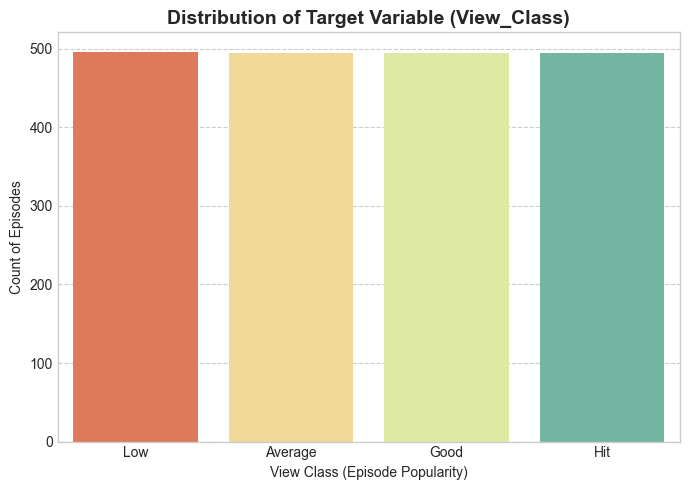

2a. Generating Text Length Boxplot...


C:\Users\rinip\AppData\Local\Temp\ipykernel_15828\3646167134.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='View_Class', y='Text_Length', data=df, order=CLASS_ORDER, palette='viridis')


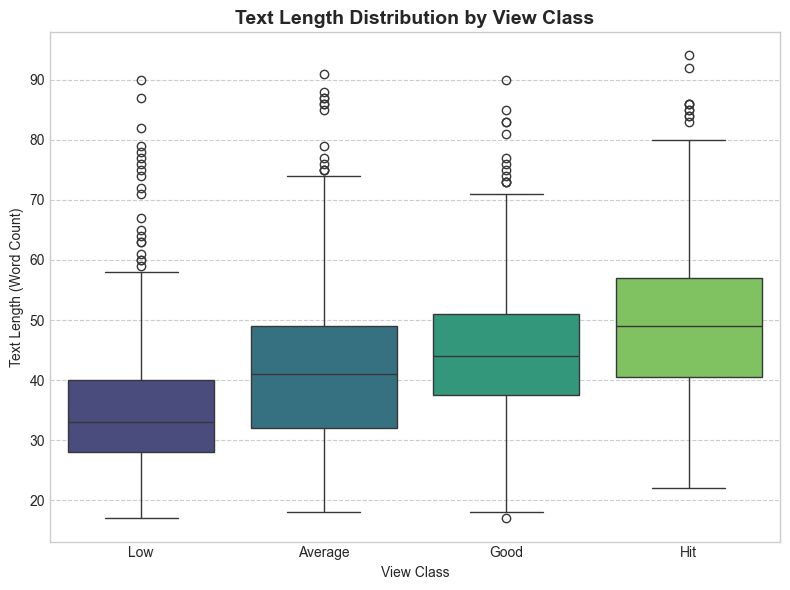

2b. Generating Sentiment Score Histogram...


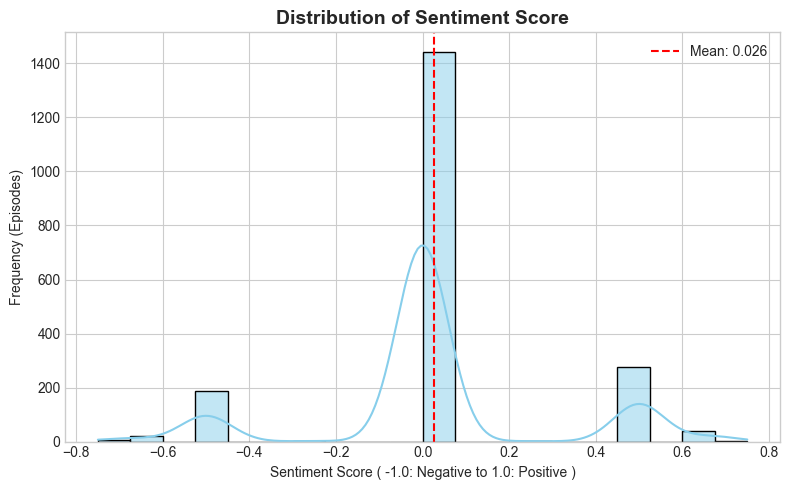


3. Generating Correlation Heatmap...


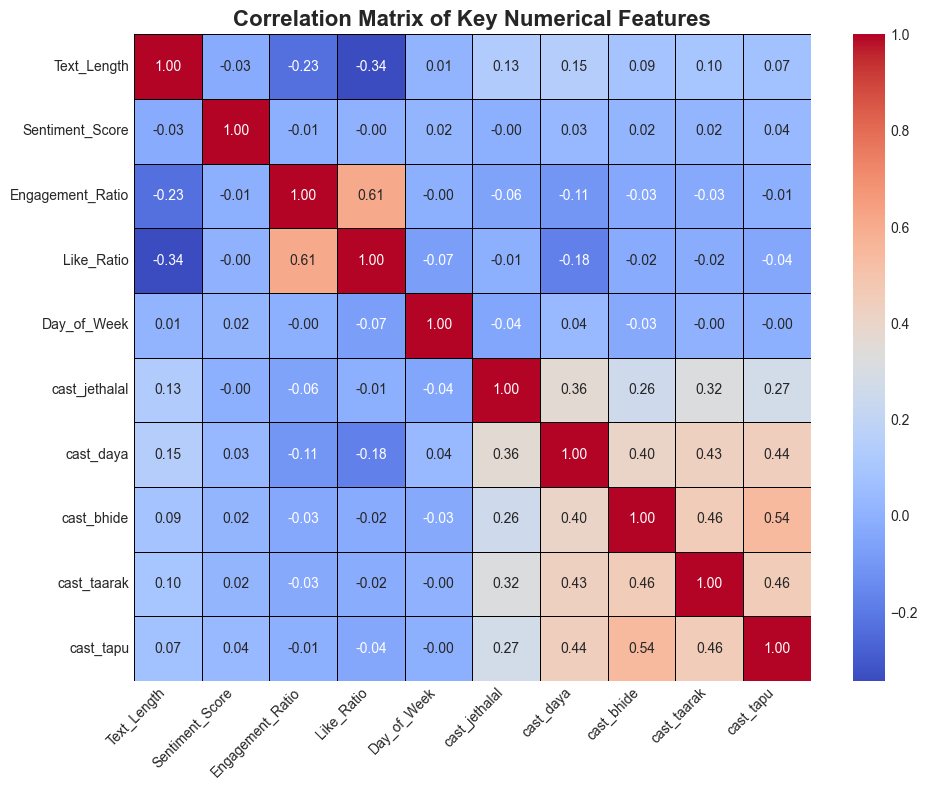


4. Running Hypothesis Test (T-test)...

--- Statistical Analysis: T-test Results ---
Hypothesis: Is Sentiment Score different between 'Hit' and 'Low' episodes?
Mean Sentiment Score ('Hit' episodes): 0.0350
Mean Sentiment Score ('Low' episodes): 0.0259
T-statistic: 0.5224
P-value: 0.601517
Conclusion: Fail to Reject Null Hypothesis (P > 0.05). The difference is NOT statistically significant.

5. Displaying Summary Statistics (EDA Insights)...

--- Descriptive Statistics Table ---
                   count       mean        std        min        25%  \
Text_Length       1981.0  43.008077  13.361559  17.000000  33.000000   
Sentiment_Score   1981.0   0.025660   0.271121  -0.750000   0.000000   
Engagement_Ratio  1981.0   0.016769   0.009799   0.000000   0.011822   
Like_Ratio        1981.0   0.922265   0.265655   0.300185   0.714010   
Day_of_Week       1981.0   2.589601   1.606072   0.000000   2.000000   
cast_jethalal     1981.0   0.688036   0.463412   0.000000   0.000000   
cast_daya  

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

# Set Matplotlib style for professional-looking plots
plt.style.use('seaborn-v0_8-whitegrid')

# Load the final feature-engineered dataset from Experiment 2
file_name = "TMKOC_Cleaned_FeatureEngineered_Final_V3.csv"
df = pd.read_csv(file_name)

print("--- Experiment 3: Exploratory Data Analysis and Statistical Analysis ---")

# Define the order for the target variable for consistent plotting
CLASS_ORDER = ['Low', 'Average', 'Good', 'Hit']

# --- 1. Plot Class Balance (Target Distribution) ---
print("\n1. Generating Class Balance Plot...")
plt.figure(figsize=(7, 5))
sns.countplot(x='View_Class', data=df, order=CLASS_ORDER, palette='Spectral')
plt.title('Distribution of Target Variable (View_Class)', fontsize=14, fontweight='bold')
plt.xlabel('View Class (Episode Popularity)')
plt.ylabel('Count of Episodes')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# --- 2. Histograms and Boxplots ---

# 2a. Boxplot: Text_Length vs. View_Class (Visualizing Feature Separation)
print("2a. Generating Text Length Boxplot...")
plt.figure(figsize=(8, 6))
sns.boxplot(x='View_Class', y='Text_Length', data=df, order=CLASS_ORDER, palette='viridis')
plt.title('Text Length Distribution by View Class', fontsize=14, fontweight='bold')
plt.xlabel('View Class')
plt.ylabel('Text Length (Word Count)')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# 2b. Histogram: Sentiment Score Distribution
print("2b. Generating Sentiment Score Histogram...")
plt.figure(figsize=(8, 5))
sns.histplot(df['Sentiment_Score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Sentiment Score', fontsize=14, fontweight='bold')
plt.xlabel('Sentiment Score ( -1.0: Negative to 1.0: Positive )')
plt.ylabel('Frequency (Episodes)')
plt.axvline(df['Sentiment_Score'].mean(), color='red', linestyle='--', label=f'Mean: {df["Sentiment_Score"].mean():.3f}')
plt.legend()
plt.tight_layout()
plt.show()

# --- 3. Heatmap for Correlation Matrix ---
print("\n3. Generating Correlation Heatmap...")
# Select numerical features for correlation analysis
correlation_cols = ['Text_Length', 'Sentiment_Score', 'Engagement_Ratio', 'Like_Ratio', 'Day_of_Week']
# Select 5 key cast features (as binary numerical features)
cast_cols_sample = [col for col in df.columns if col.startswith('cast_')][:5]
correlation_cols.extend(cast_cols_sample)

corr_df = df[correlation_cols]
corr_matrix = corr_df.corr()

plt.figure(figsize=(10, 8))
# Use 'coolwarm' for professional color scheme
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=.5, linecolor='black')
plt.title('Correlation Matrix of Key Numerical Features', fontsize=16, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 4. T-test for Mean Differences (Hypothesis Testing) ---
print("\n4. Running Hypothesis Test (T-test)...")
# Hypothesis: Is the mean Sentiment_Score significantly different between 'Hit' and 'Low' episodes?

hit_sentiment = df[df['View_Class'] == 'Hit']['Sentiment_Score']
low_sentiment = df[df['View_Class'] == 'Low']['Sentiment_Score']

# Perform an independent two-sample t-test (Welch's t-test for unequal variance is safer)
t_stat, p_value = stats.ttest_ind(hit_sentiment, low_sentiment, equal_var=False)

print("\n--- Statistical Analysis: T-test Results ---")
print("Hypothesis: Is Sentiment Score different between 'Hit' and 'Low' episodes?")
print(f"Mean Sentiment Score ('Hit' episodes): {hit_sentiment.mean():.4f}")
print(f"Mean Sentiment Score ('Low' episodes): {low_sentiment.mean():.4f}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.6f}")

# Determine significance
alpha = 0.05
if p_value < alpha:
    print(f"Conclusion: Reject Null Hypothesis (P < {alpha}). The difference is statistically significant.")
else:
    print(f"Conclusion: Fail to Reject Null Hypothesis (P > {alpha}). The difference is NOT statistically significant.")

# --- 5. Document EDA Insights (Summary Statistics) ---
print("\n5. Displaying Summary Statistics (EDA Insights)...")
# Summary statistics for the numerical features
eda_summary = df[correlation_cols].describe().T

print("\n--- Descriptive Statistics Table ---")
print(eda_summary)
